# Using VAEs as a Data Augmentation Technic
## Observations
 - Slightly improves f1-scores in few-shot scenarios
 - only yields improvments when generated samples do NOT dominate the original samples, i.e. do not generate more examples than the original dataset holds!
 - for non-few-shot scenarios the augmentation leads to faster and more stable convergence but not to an overall better performance of the model
 - often the f1-scores tend to rise faster when using additional generated data espiacially in early stages of training (first ~100 steps)
 - it seems like one cannot train the VAEs enough. The longer the better, which is weird because usually this means that the generated samples are very close to the original ones used for training

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore') # suppress pytorch_lightning warnings

In [3]:
# set seed
seed = 42
# set cudnn backend to be deterministic
torch.backends.cudnn.deterministic = True
# utility function for seeding
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Hyperparameters

In [4]:
# data hyperparameters
dataset_name = "thyroid"
n_generated_perc = 0.5          # total number of examples to be generated
balancing = True                # Switches the way the number of examples per class is computed
# vae hyperparamters
vae_z_dim = 4                   # latent space dimension for vae
vae_training_steps = 3000       # number of training steps for the vae
vae_beta = 1.0 * 2/21           # beta parameter of the kl-loss term
vae_batch_size = 32             # batch size for vae training
# gc hyperparameters
gc_training_steps = 800         # number of training steps for the gan
gc_batch_size = 32              # batch size for gan training
gc_std = 0.01                   # std used for adjusting normal noise
# cnn model hyperparameters
cls_training_steps = 3000       # number of training steps for the cnn
cls_batch_size = 32             # batch size for cnn training
early_stopping_patience = 4     # patience parameter for early stopping
N, M, K = 512, 256, 128         # gc and classifier model parameters
# output dir for plots
plot_dir = Path(f"plots/PROBEN1_normal/{dataset_name}/{n_generated_perc}-{vae_z_dim}-{vae_training_steps}-{vae_beta}-{vae_batch_size}-{N}-{M}-{K}-{gc_training_steps}-{gc_batch_size}-{gc_std}-{cls_training_steps}-{cls_batch_size}-{early_stopping_patience}")
plot_dir.mkdir(exist_ok=True, parents=True)

## Data Preparation


In [5]:
# load data and labels
data = np.loadtxt(Path(f"../datasets/proben1/{dataset_name}_data.txt").expanduser())
labels = np.loadtxt(Path(f"../datasets/proben1/{dataset_name}_labels.txt").expanduser())
# remember the shape of the data
in_feat = data.shape[1]
n_classes = len(np.unique(labels))
# split data into train & test parts
seed_everything(seed)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, stratify=labels, shuffle=True, random_state=seed)
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
# only use the first iteration of cross-validation
seed_everything(seed)
train_index, val_index = next(iter(skf.split(x_train, y_train)))
# select data by cross-validation index
x_train, x_val = data[train_index], data[val_index]
y_train, y_val = labels[train_index], labels[val_index]
# separate train/valid data into the different classes
train_per_label = [x_train[y_train == i] for i in range(n_classes)]
# pack testing data into dataset
test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))
# pack validation data into dataset
val_dataset = TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val))

In [6]:
# compute number of examples to generate for each class
n_total = sum([X.shape[0] for X in train_per_label])
# x is the proportion of each class in the dataset
x = np.array([count / n_total for count in [X.shape[0] for X in train_per_label]])
# if balancing the number of generated examples is computed differently
if balancing:
    n_generated_per_class = np.round((1 - x) / (n_classes - 1) * np.round(n_generated_perc * n_total)).astype('int')
else:
    n_generated_per_class = np.round(x * np.round(n_generated_perc * n_total)).astype('int')
# print class counts and number of generated per class
print(f"class_counts = {[X.shape[0] for X in train_per_label]}")
print(f"n_generated_per_class = {n_generated_per_class}")

class_counts = [139, 306, 5387]
n_generated_per_class = [1423 1382  111]


# Variational Auto-Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_feat, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
        )
        self.mean = nn.Linear(64, z_dim)
        self.log_variance = nn.Linear(64, z_dim)
    def forward(self, x):
        seq_out = self.sequential(x)
        # actually computes the log of the variance
        return self.mean(seq_out), self.log_variance(seq_out)
class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, in_feat),
            nn.Sigmoid(),
        )
    def forward(self, z):
        return self.sequential(z)
class VAE(pl.LightningModule):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    def forward(self, x):
        # encode
        m, v_log = self.encoder(x)
        if self.training:
            # sample from encoding
            eps = torch.empty_like(v_log).normal_()
            z = eps * (v_log / 2).exp() + m
        else:
            z = m
        # decode from sample
        x_ = self.decoder(z)
        # return reconstruction, mean and log_variance
        return x_, m, v_log
    def training_step(self, batch, batch_idx):
        x, y = batch
        # encode
        x_, m, v_log = self(x)
        # compute loss
        r_l = F.binary_cross_entropy(x_, x) * in_feat
        kl_l = (v_log.exp() + m**2 - 1 - v_log).sum(-1).mean()
        # log loss
        self.log_dict({"train_r_l": r_l.item(), "train_kl_l": kl_l.item()}, prog_bar=True, on_step=True)
        # return weighted loss
        return r_l + vae_beta * kl_l
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4, weight_decay=0.01, betas=[0.5, 0.9])

In [8]:
seed_everything(seed)
# create one VAE model for each class
vae_per_label = [VAE(z_dim=vae_z_dim) for _ in range(n_classes)]

### Training the VAE Models

In [9]:
seed_everything(seed)
# train each vae on the specific data
for i, (x_train_i, vae) in enumerate(zip(train_per_label, vae_per_label)):
    # pack train data into dataset
    train_dataset_i = TensorDataset(torch.FloatTensor(x_train_i), torch.LongTensor([i] * x_train_i.shape[0]))
    # create dataloaders
    train_dataloader_i = DataLoader(train_dataset_i, batch_size=vae_batch_size, shuffle=True, drop_last=True)
    # trainer setup
    trainer = pl.Trainer(max_steps=vae_training_steps, gpus=1, weights_summary=None, checkpoint_callback=False, logger=False)
    # train model
    trainer.fit(vae, train_dataloader_i)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]

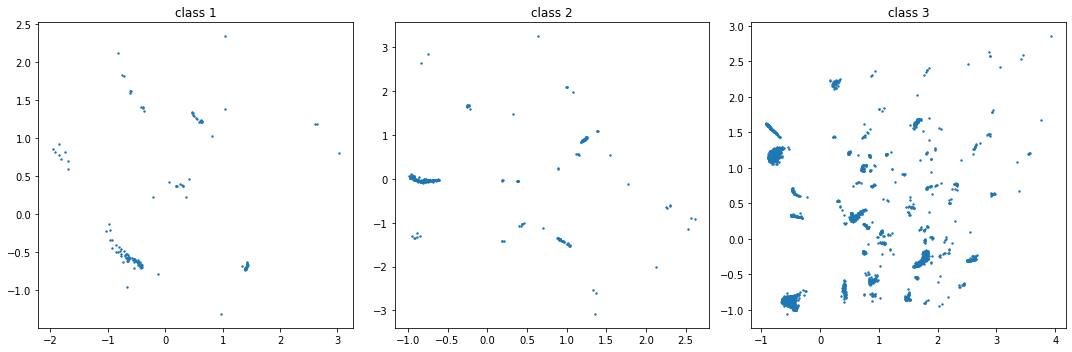

In [10]:
figure(tight_layout=True, figsize=(5 * n_classes, 5))
with torch.no_grad():
    for i, (vae, x_train) in enumerate(zip(vae_per_label, train_per_label), start=1):
        z = vae.encoder(torch.FloatTensor(x_train))[0]
        # plot
        subplot(1, n_classes, i)
        if z.shape[1] == 1:
            scatter(z, torch.zeros_like(z), s=2)
        elif z.shape[1] == 2:
            scatter(*z.T, s=2)
        else:
            scatter(*PCA(2).fit_transform(z).T, s=2)
        title(f"class {i}")
savefig(plot_dir / f"feature_space.pdf")
show()

Original Examples


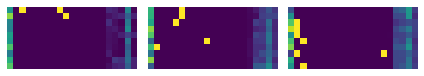

VAE Examples


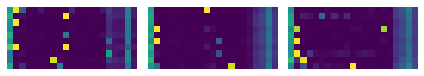

In [11]:
# plot original
print("Original Examples")
figure(tight_layout=True)
for i, X in enumerate(train_per_label, start=1):
    subplot(1, n_classes, i)
    imshow(X[:10].reshape(-1, in_feat))
    axis("off")
savefig(plot_dir / "original_data.pdf")
show()
# generate new examples from normal distribution
z_rand = torch.empty(10, vae_z_dim).normal_(0, 1)
with torch.no_grad():
    x_gen_per_class = [
        vae.decoder.forward(z_rand).reshape(-1, in_feat)
        for vae in vae_per_label
    ]
# plot vae examples
print("VAE Examples")
figure(tight_layout=True)
for i, x_gen in enumerate(x_gen_per_class, start=1):
    subplot(1, n_classes, i)
    imshow(x_gen.numpy())
    axis("off")
savefig(plot_dir / "vae_data.pdf")
show()

# Generative Classifier
We train a classifier to decide which images are generated by an vae and which ones aren't. By only training the model for a few steps we hope to ensure that the vae still generates images that are not discarded by the generative classifier.

In [12]:
class GenerativeClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential( 
            # input size: in_feat
            nn.Linear(in_feat, N),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(N),
            nn.Dropout(0.1, inplace=True),
            # state size: N
            nn.Linear(N, M),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(M),
            nn.Dropout(0.1, inplace=True),
            # state size: M
            nn.Linear(M, K),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(K),
            nn.Dropout(0.1, inplace=True),
            # state size: K
            nn.Linear(K, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.sequential(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        # forward
        y_ = self(x).flatten()
        # return loss
        return F.binary_cross_entropy(y_, y)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4, weight_decay=0.01)

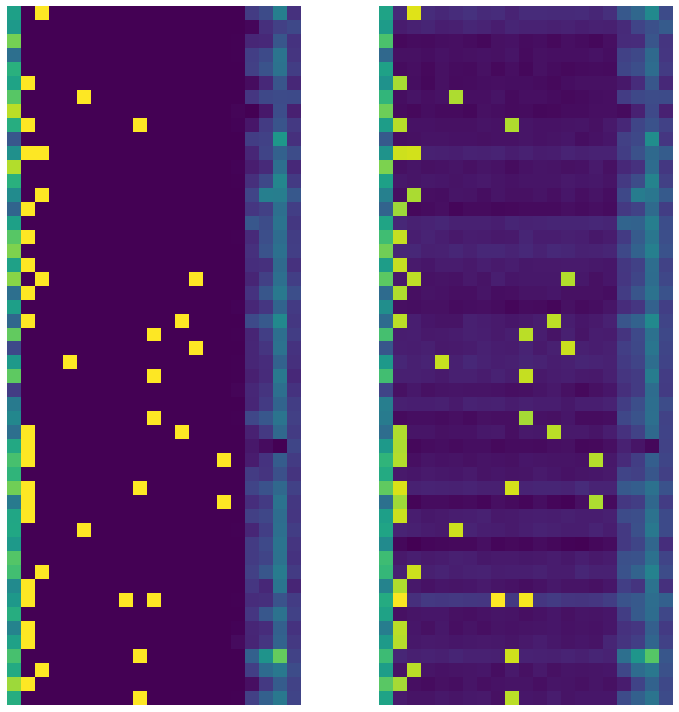

In [13]:
seed_everything(seed)
# build dataset of fake and real samples
real_x = torch.FloatTensor(np.concatenate(train_per_label, axis=0))
# create n/2 uniform distributed datapoints
uniform = torch.rand(size=(real_x.size(0) // 2, *real_x.size()[1:]))
# compute mean of dataset
feature_means = real_x.mean(dim=1)
# create n/2 normal distributed datapoints by adding normal noise to n/2 of the dataset
idx = torch.randperm(real_x.size(0))[: real_x.size(0) // 2]
# create normal noise with sample mean and std=0.3
normal = torch.stack([torch.normal(mean, gc_std, size=real_x.size()[1:]) for mean in feature_means[:real_x.size(0) // 2]], dim=0)
normal += real_x[idx]
# normalize normal noise examples
_min = normal.flatten(-2).min(-1)[0].unsqueeze(-1).unsqueeze(-1)
_max = normal.flatten(-2).max(-1)[0].unsqueeze(-1).unsqueeze(-1)
normal = (normal - _min) / (_max - _min)

# fake_x = torch.cat([uniform, normal], dim=0)
fake_x = torch.cat([uniform, normal], dim=0)
# create labels
real_y = torch.ones(real_x.size(0))
fake_y = torch.zeros(fake_x.size(0))
# pack into dataloader
gc_dataloader = DataLoader(
    TensorDataset(torch.cat((real_x, fake_x), dim=0), torch.cat((real_y, fake_y), dim=0)), batch_size=gc_batch_size, shuffle=True, drop_last=True
)
# visualize the data used to train the gc
_, (ax_original, ax_noisy) = subplots(1, 2, tight_layout=True, figsize=(20, 10))
ax_original.imshow(real_x[idx][:50].numpy().reshape(1, 50, 1, in_feat).transpose(1, 2, 0, 3).reshape(50, in_feat))
ax_original.axis("off")
ax_noisy.imshow(normal[:50].numpy().reshape(1, 50, 1, in_feat).transpose(1, 2, 0, 3).reshape(50, in_feat))
ax_noisy.axis("off")
plt.savefig(plot_dir / "gc_train_data.pdf")
show()

In [14]:
seed_everything(seed)
# train generative classifier
gc = GenerativeClassifier()
trainer = pl.Trainer(max_steps=gc_training_steps, gpus=1, weights_summary=None, checkpoint_callback=False, logger=False)
_ = trainer.fit(gc, gc_dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]

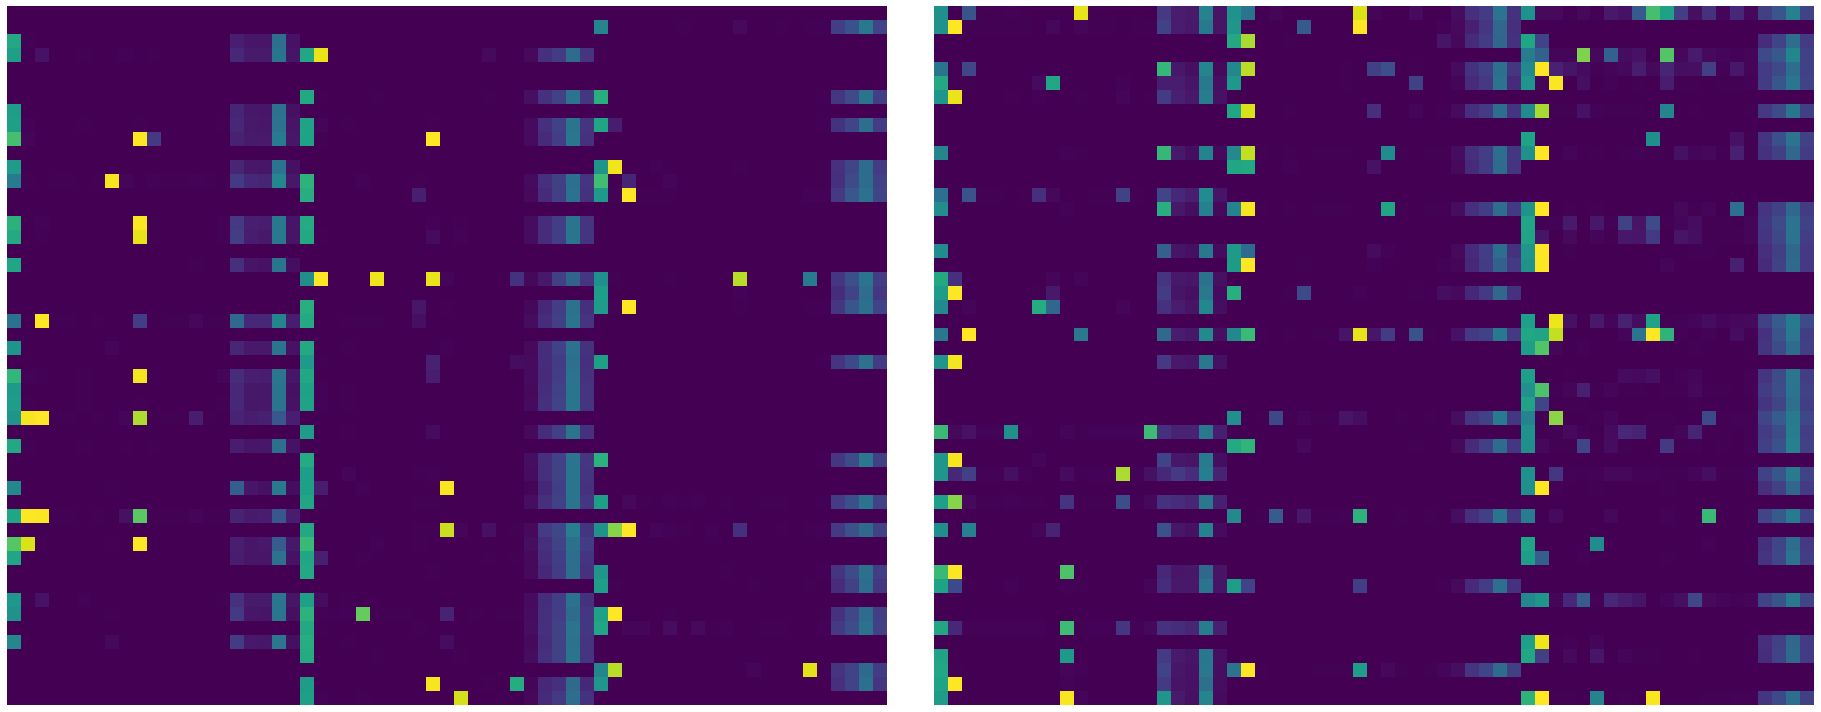

In [15]:
# generate some samples
with torch.no_grad():
    z_rand = torch.empty(50, vae_z_dim).normal_(0, 1)
    x_gen = torch.cat([
        vae.decoder.forward(z_rand)
        for vae in vae_per_label
    ], dim=0)
    # apply generative classifier
    mask = (gc.forward(x_gen) > 0.5).squeeze()
# convert to numpy
x_gen = x_gen.numpy()
mask = mask.numpy()
# apply mask
x_good, x_bad = x_gen.copy(), x_gen.copy()
x_good[~mask], x_bad[mask] = 0, 0

# visualize the choice of
# the generative classifier
_, (ax_good, ax_bad) = subplots(1, 2, tight_layout=True, figsize=(30, 10))
ax_good.imshow(x_good.reshape(n_classes, 50, 1, in_feat).transpose(1, 2, 0, 3).reshape(50, n_classes * in_feat))
ax_good.axis("off")
ax_bad.imshow(x_bad.reshape(n_classes, 50, 1, in_feat).transpose(1, 2, 0, 3).reshape(50, n_classes * in_feat))
ax_bad.axis("off")
savefig(plot_dir / "gc_good_bad.pdf")
show()

# CNN Model as Baseline

In [16]:
class Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # tracks losses
        self.all_train_losses = []
        self.all_val_losses = []
        # tracks accuracies
        self.val_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()
        self.all_val_accs = []
        # model
        self.sequential = nn.Sequential(
            # input size: in_feat
            nn.Linear(in_feat, N),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(N),
            nn.Dropout(0.1, inplace=True),
            # state size: N
            nn.Linear(N, M),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(M),
            nn.Dropout(0.1, inplace=True),
            # state size: M
            nn.Linear(M, K),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(K),
            nn.Dropout(0.1, inplace=True),
            # state size: K
            nn.Linear(K, n_classes),
            nn.LogSoftmax(dim=-1)
        )
    def forward(self, x):
        return self.sequential(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        # encode
        y_ = self(x)
        # compute loss
        loss = F.nll_loss(y_, y)
        # log loss
        self.all_train_losses.append(loss.item())
        # return weighted loss
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # get prediction
        y_ = self(x)
        # compute loss
        loss = F.nll_loss(y_, y)
        # compute accuracy
        self.val_acc(y_.argmax(-1), y)
        # log loss & accuracy
        self.log_dict({"val_loss": loss, "val_acc": self.val_acc})
        # return loss & accuracy for validation_epoch_end
        return {"loss": loss.item(), "val_acc": self.val_acc.compute().item()}
    def validation_epoch_end(self, outputs):
        self.all_val_losses.append(np.average([output["loss"] for output in outputs]))
        self.all_val_accs.append(np.average([output["val_acc"] for output in outputs]))
    def test_step(self, batch, batch_idx):
        x, y = batch
        # encode
        y_ = self(x)
        # compute loss
        loss = F.nll_loss(y_, y)
        # compute accuracy
        self.test_acc(y_.argmax(-1), y)
        # log the outputs!
        self.log_dict({'test_loss': loss, 'test_acc': self.test_acc})
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4, weight_decay=0.01)

### Training script for the CNN Model

In [17]:
def train_classifier(train_dataset, val_dataset, test_dataset):
    # create dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=cls_batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=512)
    test_dataloader = DataLoader(test_dataset, batch_size=512)
    # create a cnn model
    model = Classifier()
    # early stopping callback
    early_stop_callback = EarlyStopping(
       monitor='val_acc',
       min_delta=0.00,
       patience=early_stopping_patience,
       verbose=False,
       mode='max'
    )
    # trainer setup
    trainer = pl.Trainer(max_steps=cls_training_steps, callbacks=[early_stop_callback], gpus=1, weights_summary=None, checkpoint_callback=False, logger=False)
    # train model
    trainer.fit(model, train_dataloader, val_dataloader)
    # test model
    seed_everything(seed)
    results = trainer.test(model, test_dataloader)
    # return model and tracked values
    return model, {
        "train-losses": model.all_train_losses,
        "val-losses": model.all_val_losses,
        "val-accs": model.all_val_accs,
        "test-acc": results[0]["test_acc"],
    }

### Training models
Here we train three models, i.e.
 - one trained on only the originally provided (reduced!) dataset
 - one trained on the original together with some generated samples
 - and one where the generated examples are filtered by the generative classifier

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9597222208976746, 'test_loss': 0.12948957085609436}
--------------------------------------------------------------------------------


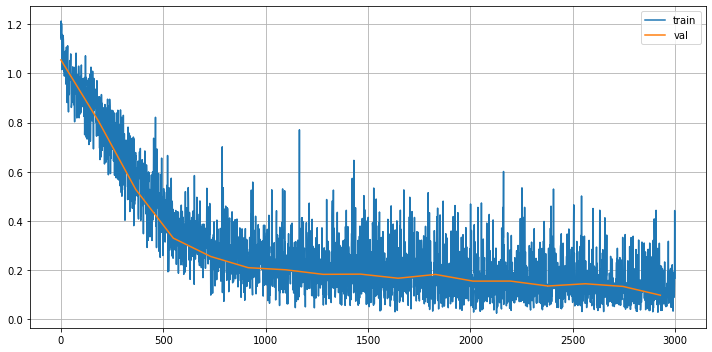

In [18]:
seed_everything(seed)
# build dataset of only the original samples
orig_train_dataset = TensorDataset(
    torch.FloatTensor(np.concatenate(train_per_label, axis=0)),
    torch.LongTensor(np.concatenate([
        (np.zeros(X.shape[0]) + i) for i, X in enumerate(train_per_label)
    ], axis=0))
)
# train model on dataset
model_orig, metrics_orig = train_classifier(orig_train_dataset, val_dataset, test_dataset)
# plot the losses
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_orig['train-losses'], label='train')
ticks = [i * np.ceil(len(orig_train_dataset) / (cls_batch_size)) for i in range(len(metrics_orig['val-losses']))]
plot(ticks, metrics_orig['val-losses'], label='val')
legend()
savefig(plot_dir / "classifier_loss_orig.pdf")
show()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9583333134651184, 'test_loss': 0.11500155180692673}
--------------------------------------------------------------------------------


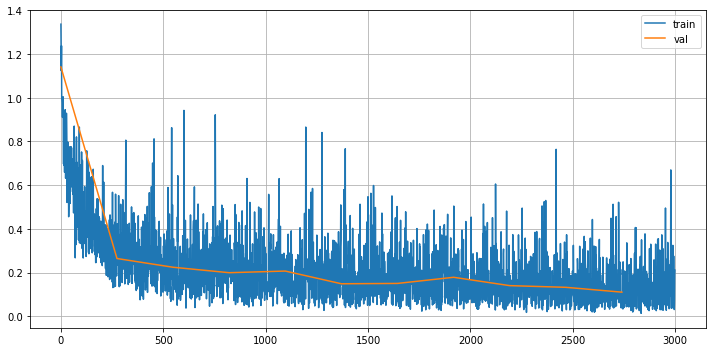

In [19]:
seed_everything(seed)
# build a dataset with both the original samples
# and also some generated ones using the vaes
with torch.no_grad():
    z_rand_per_class = [torch.empty(n_generated, vae_z_dim).normal_(0, 1) for n_generated in n_generated_per_class]
    generated_per_label = [
        vae.decoder.forward(z_rand).numpy()
        for (vae, z_rand) in zip(vae_per_label, z_rand_per_class)
    ]
# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen, metrics_gen = train_classifier(full_train_dataset, val_dataset, test_dataset)
# plot training and test losses
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_gen['train-losses'], label='train')
ticks = [i * np.ceil(len(full_train_dataset) / (cls_batch_size)) for i in range(len(metrics_gen['val-losses']))]
plot(ticks, metrics_gen['val-losses'], label='val')
legend()
savefig(plot_dir / "classifier_loss_full.pdf")
show()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Generated Examples: [1423, 1382, 111]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9611111283302307, 'test_loss': 0.11033691465854645}
--------------------------------------------------------------------------------


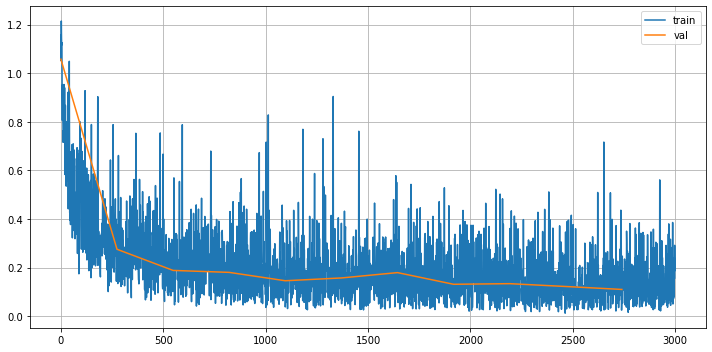

In [20]:
seed_everything(seed)
# build a dataset with both the original samples
# and also some generated ones using the vaes
with torch.no_grad():
    z_rand_per_class = [torch.empty(n_generated * 30, vae_z_dim).normal_(0, 1) for n_generated in n_generated_per_class]
    generated_per_label = [
        vae.decoder.forward(z_rand)
        for (vae, z_rand) in zip(vae_per_label, z_rand_per_class)
    ]
    # apply generative classifier
    masks_per_label = [
        gc.forward(x_gen).flatten() > 0.5
        for x_gen in generated_per_label
    ]
    generated_per_label = [
        x_gen[mask, ...].numpy()[:n_generated, ...]
        for x_gen, mask, n_generated in zip(generated_per_label, masks_per_label, n_generated_per_class)
    ]
    print(f"Generated Examples: {[x_gen.shape[0] for x_gen in generated_per_label]}")

# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen_gc, metrics_gen_gc = train_classifier(full_train_dataset, val_dataset, test_dataset)
# plot training and test losses
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_gen_gc['train-losses'], label='train')
ticks = [i * np.ceil(len(full_train_dataset) / (cls_batch_size)) for i in range(len(metrics_gen_gc['val-losses']))]
plot(ticks, metrics_gen_gc['val-losses'], label='val')
legend()
savefig(plot_dir / "classifier_loss_gc.pdf")
show()

### Comparisson of F1-Scores

Without Generated:	 0.9597
With Generated:		 0.9583
With Generated+GC:	 0.9611


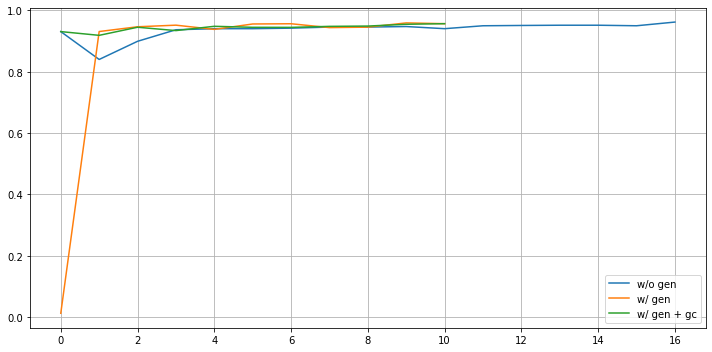

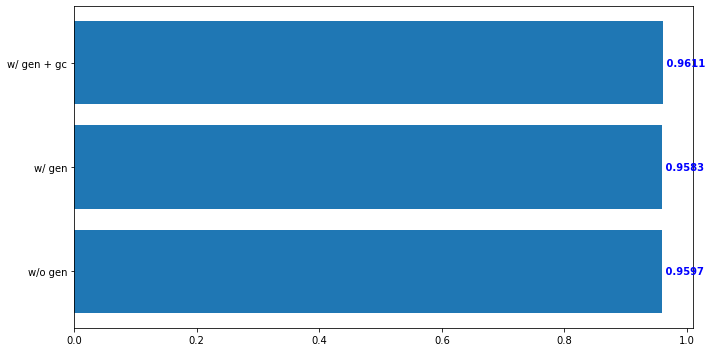

In [21]:
# compare f1 scores of both models
print("Without Generated:\t", round(metrics_orig['test-acc'], 4))
print("With Generated:\t\t", round(metrics_gen["test-acc"], 4))
print("With Generated+GC:\t", round(metrics_gen_gc["test-acc"], 4))
# also plot
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_orig["val-accs"], label="w/o gen")
plot(metrics_gen["val-accs"], label="w/ gen")
plot(metrics_gen_gc["val-accs"], label="w/ gen + gc")
legend()
savefig(plot_dir / "val-accs.pdf")
show()

y = [
    round(metrics_orig['test-acc'], 4),
    round(metrics_gen['test-acc'], 4),
    round(metrics_gen_gc['test-acc'], 4),
]
figure(tight_layout=True, figsize=(10, 5))  
barh([0, 1, 2], y, tick_label=["w/o gen", "w/ gen", "w/ gen + gc"])
for i, v in enumerate(y):
    plt.text(v, i, f" {str(v)}", color="blue", va="center", fontweight="bold")
savefig(plot_dir / "test-acc.pdf")
show()

In [22]:
import time
from IPython.display import display, Javascript
import hashlib

def save_notebook(file_path):
    start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
    
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()

from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = 'PROBEN1_normal.ipynb'
output_file_name = plot_dir / 'output.html'

save_notebook(notebook_name)

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

<IPython.core.display.Javascript object>